This notebook shows the process to import ERA5 data optimized and scaled through the weatherbench_5.625 repository. This data is employed to create a SHT model later optimized by gradient descent. (https://github.com/pangeo-data/WeatherBench/tree/master). Credits to ChatGPT for formating the figures!

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

## Import and visualize the data

In [106]:
root = Path("datasets/weatherbench_5.625")

def open_years(var_dir, years):
    dirpath = os.path.join(root, var_dir)
    files = [
        os.path.join(dirpath, fname)
        for fname in os.listdir(dirpath)
        if any(str(y) in str(fname) for y in years)
    ]
    files.sort() 
    print(files)
    ds = xr.open_mfdataset(files, combine='by_coords')#, chunks={'time': 8})
    return ds

In [ ]:
# Choose a small split
years = [2015, 2016, 2017, 2018]

In [ ]:
t850_dat = open_years("temperature_850_5.625deg",  years)

['datasets/weatherbench_5.625/temperature_850_5.625deg/temperature_850hPa_2015_5.625deg.nc', 'datasets/weatherbench_5.625/temperature_850_5.625deg/temperature_850hPa_2016_5.625deg.nc', 'datasets/weatherbench_5.625/temperature_850_5.625deg/temperature_850hPa_2017_5.625deg.nc']


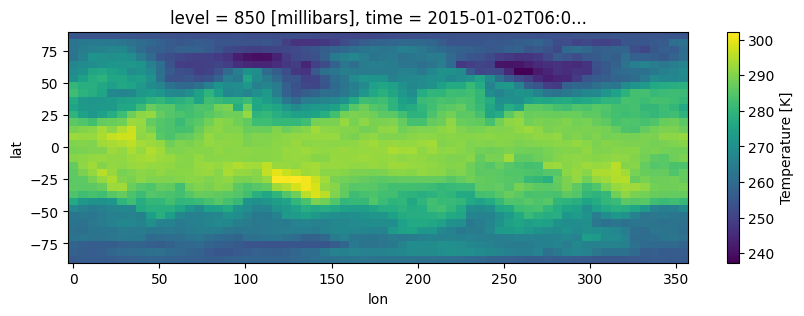

In [6]:
#Visualize data for a given hour
t850_dat.t.isel(time=30).plot(figsize=(10,3));

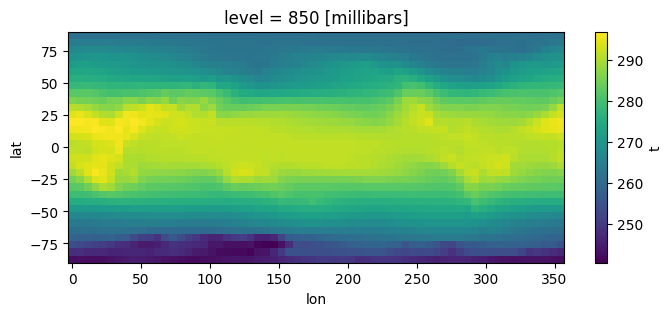

In [7]:
### Samll model with the average of a year
climatology = t850_dat.sel(time=slice('2016', '2016')).mean('time').load()
climatology.t.plot(figsize=(8,3))

## Spherical Harmonic Transformation

### Construct the coefficients for SHT.

In [10]:
from torch_harmonics import *
import torch
import torch.nn as nn
import torch.fft as fft

In [11]:
# Convert data to radians and select timerange
data = t850_dat.sel(time=slice('2015', '2018'))
data = data.assign_coords(lon=data.t.lon/180*np.pi-np.pi)
data = data.assign_coords(lat=data.t.lat/180*np.pi)

For this case, both coordinates (lat and lon) are already in a grid with power of 2 dimensions (lon 64 and lat 32). Otherwise conversion would be requried.

In [12]:
lambdas = np.array(data.t.lon)
n_lambda = len(lambdas)
thetas = np.array(data.t.lat)
n_theta = len(thetas)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
### Here for convinience I translate to numpy but loose the chunks benefit. Pending fix for larger datasets.
temp_data = torch.from_numpy(np.array(data.t.data))
temp_data = temp_data/temp_data.max() # Normalize I guess
temp_data_static = temp_data[0] #Select first point in time

In [113]:
temp_data.shape

torch.Size([26304, 32, 64])

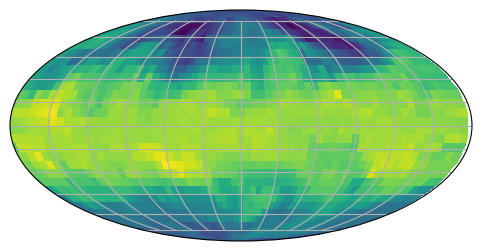

In [15]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(lambdas, thetas, temp_data_static)
# ax.set_title("temperature Earth")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [16]:
sht = RealSHT(n_theta, n_lambda, grid="equiangular").to(device)
isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular").to(device)

Note that the coefficients $\hat{u}$ of the spherical harmonics $Y_{l,m}$ can be obtained with the SHT which is a convolution.

$u(\theta, \phi) = \sum_{l \in \mathbb{N}} \sum_{|m| \leq l} \hat{u}(l,m) \, Y_l^m(\theta, \phi)$

In [17]:
signal = temp_data_static.to(device)
coeffs = sht(signal)

/var/folders/01/t0tyw8pn5b12d671zydx4_dc0000gn/T/ipykernel_1635/1304946716.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


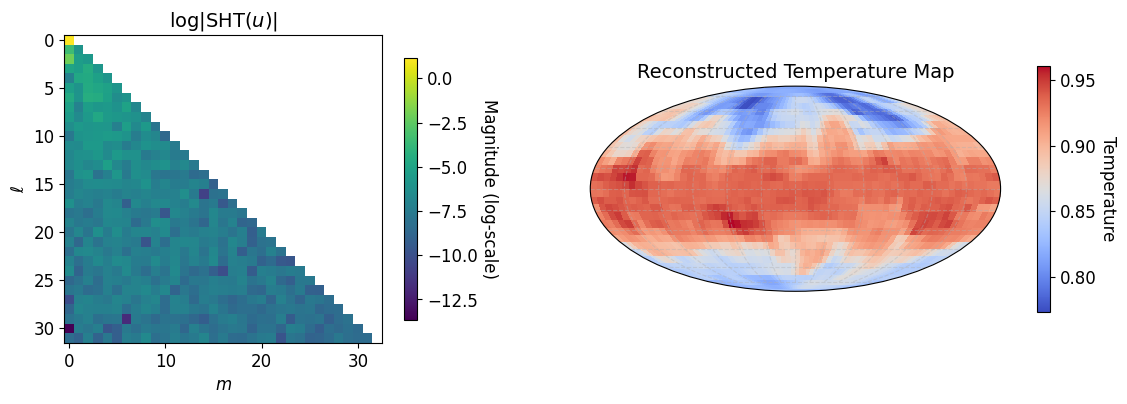

In [18]:
# --- Global figure style ---
mpl.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "figure.titlesize": 16,
})

fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2], wspace=0.25)

# ===============================================================
#  LEFT PANEL: log-magnitude of spectral coefficients
# ===============================================================
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(
    coeffs.abs().log().cpu(),
    cmap="viridis"
)

ax0.set_xlabel(r"$m$")
ax0.set_ylabel(r"$\ell$")
ax0.set_title(r"$\log | \mathrm{SHT}(u) |$")

cbar0 = fig.colorbar(im0, ax=ax0, shrink=0.85)
cbar0.ax.set_ylabel("Magnitude (log-scale)", rotation=270, labelpad=15)

# ===============================================================
#  RIGHT PANEL: Mollweide projection
# ===============================================================
ax1 = fig.add_subplot(gs[0, 1], projection='mollweide')
#Note how the map is re-constructed with applying an inverse sht with the known spectral coefficients.
griddata = isht(coeffs).cpu()

# pcolormesh requires phi in [-pi, pi]
phi = lambdas - lambdas.mean()     # recenter longitudes symmetrically

im1 = ax1.pcolormesh(
    phi,
    thetas,
    griddata,
    shading='auto',
    cmap='coolwarm'
)

ax1.set_title("Reconstructed Temperature Map")
ax1.grid(alpha=0.4, linestyle="--")

# Remove labels for cleaner scientific look
ax1.set_xticklabels([])
ax1.set_yticklabels([])

cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8, pad=0.07)
cbar1.ax.set_ylabel("Temperature", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


### Spectral Coefficients retrieval by gradient descent.

**Note** The algorithm returned a lot of spectral coefficients $\hat{u}$, however the relevant ones seem to be just a few of them. (the ones with log|SHT(u)| = 0 or the ones in red color)

**Note:** the SFNO need to be differentiable so they can be trained by backpropagation. <br>
It uses ADAM (Adaptive Moment Estimation) opese to the calssical Stochastic Gradient Decent. Adam optimizes both first (mean) and second (variance) moments of the parameters.

$$
\theta \;\;\longleftarrow\;\; \theta \;-\; \eta \, \frac{\partial L}{\partial \theta}
$$
Where:

- $L$ = loss function (measures how far predictions are from the target),
- $\theta$ = model parameter (weight or bias being optimized),
- $\frac{\partial L}{\partial \theta}$ = gradient of the loss with respect to the parameter,
- $\eta$ = learning rate (step size that controls how big each update is).


### Optimize coefficients 
To reduce the error, lets optimize the parameters for gradient descent. Starting by creating the **Spectral Layer Tensor**

In [19]:
class SpectralModel(nn.Module):
    def __init__(self, n_modes, out_dims, init_triangle=False):
        super().__init__()
        #Create a tensor with the modes of the spherical coordinates (size of (n_modes, n_modes+1))
        #Tensor in complex coordinates
        #Remember coefficients hat(u) are the spectral signal
        self.coeffs = nn.Parameter(torch.randn(n_modes, n_modes+1, dtype=torch.complex128))
        # Equiangular means that the sphere coordinets theta (longitud) and lambda (latitude) are sampled equally
        self.isht = InverseRealSHT(out_dims[0], out_dims[1], lmax=n_modes, mmax=n_modes+1, grid="equiangular").to(device)
        
        if init_triangle:
            self.set_uniform_triangle()
        
    def set_uniform_triangle(self, value=5e-3):
        """Fill the lower-triangular (m <= ℓ) part of coeffs with a uniform complex value and zero everything else."""
        with torch.no_grad():
            self.coeffs.zero_()
            ell_dim, m_dim = self.coeffs.shape
            mask = torch.tril(
                torch.ones(ell_dim, m_dim, device=self.coeffs.device, dtype=torch.bool),
                diagonal=0
            )

            self.coeffs[mask] = complex(value, 0.0)


    # The output is a real-valued spherical field (this the isht)
    #It is called when doing sh_model()
    def forward(self):
        return self.isht(self.coeffs)

#### Optimize coefficients with NO initial state

Now optimize its parameters (spectral coefficients $\hat{u}$) it with ADAM's gradient descent.

In [24]:
# Note that the optimizar acumulates the modifications on the coeffs parameters.
# If this cell is run twice, the second time you will see a initial lower loss

sh_model = SpectralModel(16, (n_theta, n_lambda), init_triangle=True).to(device)

optimizer = torch.optim.Adam(sh_model.parameters(), lr = 5e-2)

losses = []

for iter in range(200):

    #Note that loss is a'graph' that is connected to the graph 'self.coeffs' via sh_model
    loss = (sh_model() - signal).pow(2).mean() #It is just the MSE

    optimizer.zero_grad() #Resets the gradient (otherwise it would accumulate!)
    
    loss.backward() #Computes the gradient of loss respect to the trainable coeffs
    #This is possible because loss is a graph connected to the coeffs graph 
    #The gradient is noe stored in self.coeffs.grad (dLoss / dcoeffs)
    losses.append([loss.item()])
    
    optimizer.step() #Updates the cofficients in the direction of lower loss

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 0.7657192227814267
iteration: 10 loss: 0.4855806633857069
iteration: 20 loss: 0.32617426650418346
iteration: 30 loss: 0.2081437390668619
iteration: 40 loss: 0.1272565173303684
iteration: 50 loss: 0.0725919708501996
iteration: 60 loss: 0.038906380017487904
iteration: 70 loss: 0.01918453342913267
iteration: 80 loss: 0.008667949401834216
iteration: 90 loss: 0.0035480066246321345
iteration: 100 loss: 0.0012999736528274592
iteration: 110 loss: 0.0004274757105848788
iteration: 120 loss: 0.0001376652398298636
iteration: 130 loss: 5.9949675960587124e-05
iteration: 140 loss: 4.5465724391818766e-05
iteration: 150 loss: 4.471297308003741e-05
iteration: 160 loss: 4.511311998697275e-05
iteration: 170 loss: 4.503050531777383e-05
iteration: 180 loss: 4.479112153439697e-05
iteration: 190 loss: 4.4632262035108146e-05


#### Do it with an initial coefficient state

In [25]:
sh_model_no_triangle = SpectralModel(16, (n_theta, n_lambda)).to(device)

optimizer = torch.optim.Adam(sh_model_no_triangle.parameters(), lr = 5e-2)

losses_no_triangle = []

for iter in range(200):

    #Note that loss is a'graph' that is connected to the graph 'self.coeffs' via sh_model
    loss = (sh_model_no_triangle() - signal).pow(2).mean() #It is just the MSE

    optimizer.zero_grad() #Resets the gradient (otherwise it would accumulate!)
    
    loss.backward() #Computes the gradient of loss respect to the trainable coeffs
    #This is possible because loss is a graph connected to the coeffs graph 
    #The gradient is noe stored in self.coeffs.grad (dLoss / dcoeffs)
    losses_no_triangle.append([loss.item()])
    
    optimizer.step() #Updates the cofficients in the direction of lower loss

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 18.506267261342547
iteration: 10 loss: 5.8132807462572575
iteration: 20 loss: 2.143343249451013
iteration: 30 loss: 0.9027956236883456
iteration: 40 loss: 0.5102653457037831
iteration: 50 loss: 0.3061488976690787
iteration: 60 loss: 0.1986312400974003
iteration: 70 loss: 0.12794514303400656
iteration: 80 loss: 0.08260575138150822
iteration: 90 loss: 0.0524208694188368
iteration: 100 loss: 0.032482244748407635
iteration: 110 loss: 0.019571828957120684
iteration: 120 loss: 0.011416929506824637
iteration: 130 loss: 0.006464123525027875
iteration: 140 loss: 0.0035393299968998378
iteration: 150 loss: 0.0018773029801743893
iteration: 160 loss: 0.0009688377299324845
iteration: 170 loss: 0.0004916424714626614
iteration: 180 loss: 0.0002513249213055914
iteration: 190 loss: 0.00013563747584909415


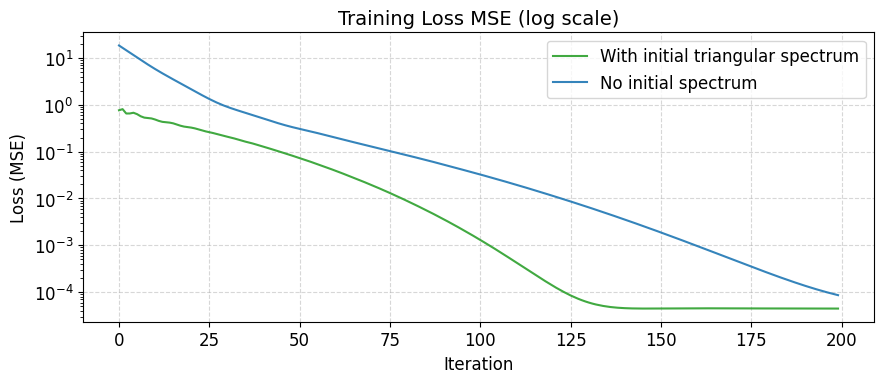

In [ ]:
# Plot training losses with a clean, informative style
loss_vals = np.array(losses).squeeze().flatten()
losses_vals_no_triangle = np.array(losses_no_triangle).squeeze().flatten()

fig, ax = plt.subplots(figsize=(9, 4))
ax.semilogy(loss_vals, color='C2', lw=1.5, alpha=0.9, label='With initial triangular spectrum')
ax.semilogy(losses_vals_no_triangle, color='C0', lw=1.5, alpha=0.9, label='No initial spectrum')


ax.set_xlabel('Iteration')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training Loss MSE (log scale)')
ax.grid(True, which='major', linestyle='--', alpha=0.5)
ax.legend(loc='upper right')


plt.tight_layout()
plt.show()

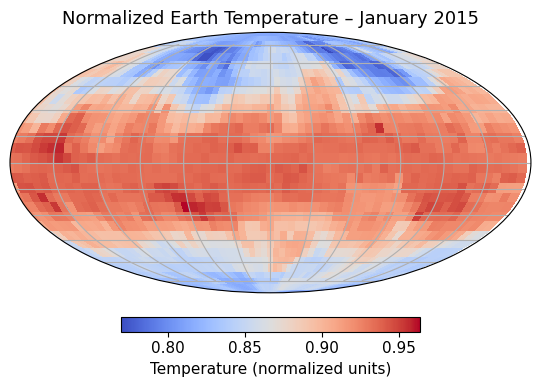

In [39]:
mpl.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "figure.titlesize": 14,
})

# Original field
orig = temp_data_static.cpu()

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')

im = ax.pcolormesh(
    lambdas, thetas, orig,
    shading='auto', cmap='coolwarm'
)

ax.set_title("Normalized Earth Temperature – January 2015")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)
cbar.set_label("Temperature (normalized units)")

plt.tight_layout()
plt.savefig('prod_figures/ERA5_data/temp_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Observations
- The optimized SHT model shows noisy predictions within each model, this predictions change drastically if the optimizer is run a second time parting from the last state of the last optimization. </br>
- The unoptimized SHT trasfrom shows smoother predictions, however it also shows great error particularly in the poles.

This unexpected behaviour (unoptimized model leading to minor errors) could be caused by the corse resolution of the data I employed. Ill try to make models with better data.


/var/folders/01/t0tyw8pn5b12d671zydx4_dc0000gn/T/ipykernel_1635/2144151481.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.90])


<Figure size 1200x1200 with 0 Axes>

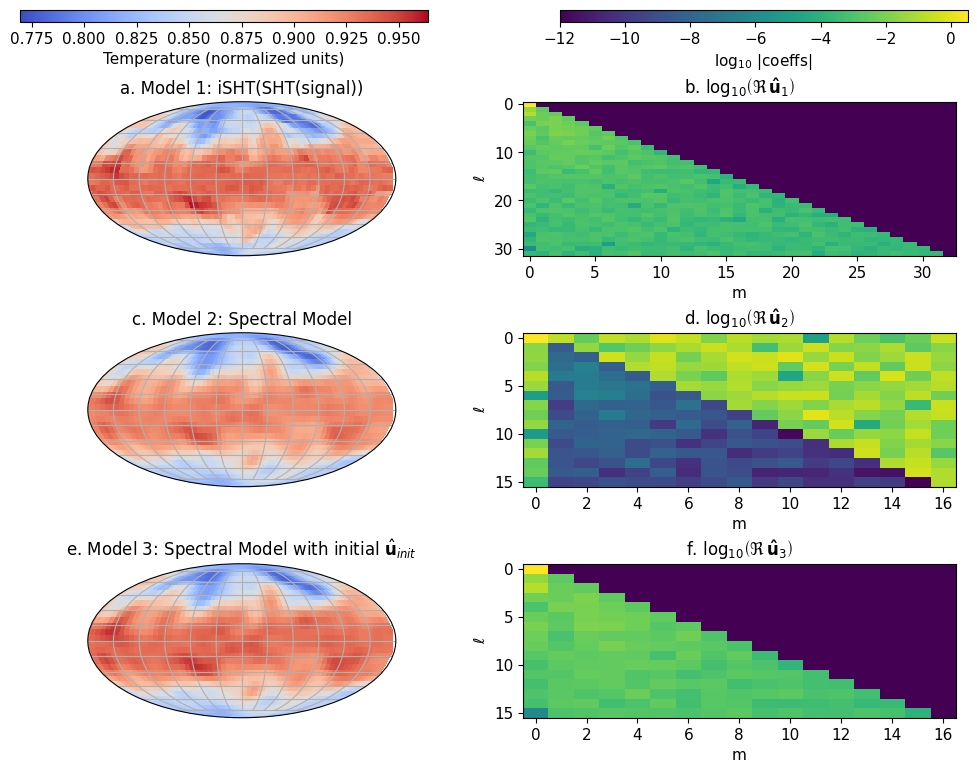

In [114]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import numpy as np

mpl.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "figure.titlesize": 14,
})

device_cpu = torch.device("cpu")

# -------------------------------------------------------------------
# Precompute all reconstructions
# -------------------------------------------------------------------
orig = temp_data_static.cpu()

# Model 1: perfect reconstruction (baseline)
recon_1 = isht(coeffs).cpu()
spec_1  = coeffs.abs().cpu()

# Model 2: trained from random init
with torch.no_grad():
    recon_2 = sh_model_no_triangle().detach().cpu()
spec_2  = sh_model_no_triangle.coeffs.detach().abs().cpu()

# Model 3: trained with triangular initialization
with torch.no_grad():
    recon_3 = sh_model().detach().cpu()
spec_3  = sh_model.coeffs.detach().abs().cpu()

# -------------------------------------------------------------------
# Limits
# -------------------------------------------------------------------
vmin_map = float(torch.min(torch.stack([orig.min(), recon_1.min(), recon_2.min(), recon_3.min()])))
vmax_map = float(torch.max(torch.stack([orig.max(), recon_1.max(), recon_2.max(), recon_3.max()])))

eps = 1e-12

# -------------------------------------------------------------------
# FIGURE 1: 3×2 comparison
# -------------------------------------------------------------------
fig = plt.figure(figsize=(12, 12))

# ===============================================================
# GRID WITH REDUCED HEIGHT FOR SPECTRUM PANELS
# Height ratios: maps are tall, spectra are shorter
# ===============================================================
fig = plt.figure(figsize=(12, 8))  # shorter figure -> rows closer

gs = fig.add_gridspec(
    3, 2,
    wspace=0.15,
    hspace=0.50      # smaller vertical spacing between rows
)

# ---------- helpers ----------
def add_map(ax, field, title):
    im = ax.pcolormesh(
        lambdas, thetas, field,
        shading="auto",
        cmap="coolwarm",
        vmin=vmin_map, vmax=vmax_map
    )
    ax.set_title(title)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

def add_spec(ax, coeffs, title):
    im = ax.imshow(
        torch.log10(coeffs + eps),
        aspect="auto",         # lets it adapt to the smaller height
        cmap="viridis"
    )
    ax.set_title(title)
    ax.set_xlabel("m")
    ax.set_ylabel("ℓ")
    return im

# ---------- row 1 ----------
ax11 = fig.add_subplot(gs[0, 0], projection='mollweide')
im11 = add_map(ax11, recon_1, "a. Model 1: iSHT(SHT(signal))")

ax12 = fig.add_subplot(gs[0, 1])
im12 = add_spec(ax12, spec_1, r"b. $\log_{10}\!\left(\Re\,\mathbf{\hat{u}}_{1}\right)$")

# ---------- row 2 ----------
ax21 = fig.add_subplot(gs[1, 0], projection='mollweide')
im21 = add_map(ax21, recon_2, "c. Model 2: Spectral Model")

ax22 = fig.add_subplot(gs[1, 1])
im22 = add_spec(ax22, spec_2, r"d. $\log_{10}\!\left(\Re\,\mathbf{\hat{u}}_{2}\right)$")

# ---------- row 3 ----------
ax31 = fig.add_subplot(gs[2, 0], projection='mollweide')
im31 = add_map(ax31, recon_3, "e. Model 3: Spectral Model with initial $\hat{\mathbf{u}}_{init}$")

ax32 = fig.add_subplot(gs[2, 1])
im32 = add_spec(ax32, spec_3, r"f. $\log_{10}\!\left(\Re\,\mathbf{\hat{u}}_{3}\right)$")

# ---------- top colorbars ----------
cbar_ax1 = fig.add_axes([0.12, 0.98, 0.34, 0.015])
cbar1 = fig.colorbar(im11, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Temperature (normalized units)")

cbar_ax2 = fig.add_axes([0.57, 0.98, 0.34, 0.015])
cbar2 = fig.colorbar(im12, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("log$_{10}$ |coeffs|")

# leave room at the top for the bars
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.90])
plt.savefig("prod_figures/ERA5_data/model_outputs.png", dpi=300, bbox_inches='tight')
plt.show()


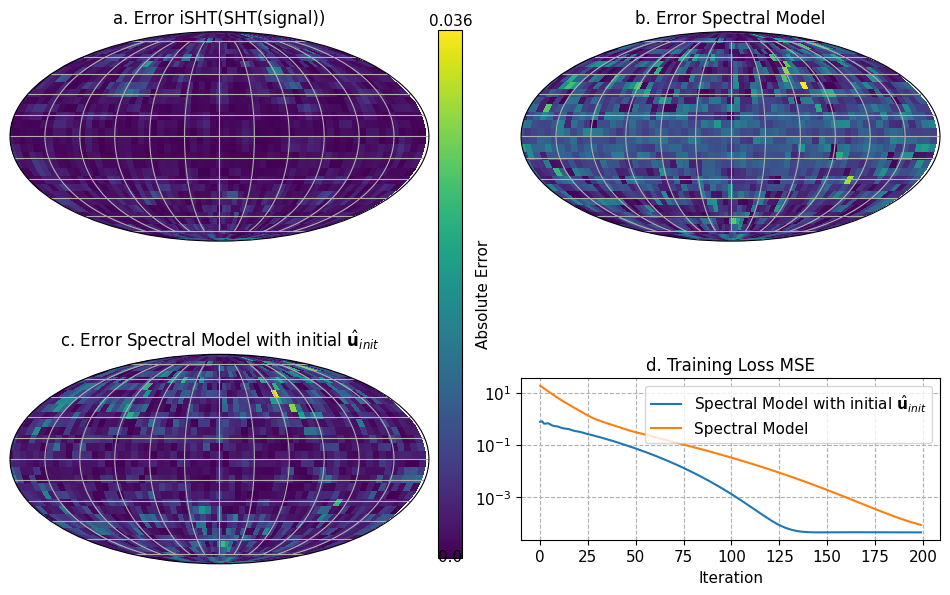

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Errors
err_1 = (recon_1 - orig).abs()
err_2 = (recon_2 - orig).abs()
err_3 = (recon_3 - orig).abs()

err_min = 0.0
err_max = float(torch.max(torch.stack([err_1.max(), err_2.max(), err_3.max()])))

fig = plt.figure(figsize=(12, 8))

# =========================================================
# Use GridSpec so all rows have equal height
# =========================================================
gs = fig.add_gridspec(
    2, 2,
    wspace=0.22,
    hspace=0.10,
    height_ratios=[1, 1]     # <-- equal height rows
)

# Helper for error mollweide maps
def add_error_moll(ax, data, title):
    im = ax.pcolormesh(
        lambdas, thetas, data,
        shading='auto', cmap='viridis',
        vmin=err_min, vmax=err_max
    )
    ax.set_title(title)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

# ------------------------------------------
# Error Model 1
# ------------------------------------------
ax11 = fig.add_subplot(gs[0,0], projection='mollweide')
im1  = add_error_moll(ax11, err_1, "a. Error iSHT(SHT(signal))")

# ------------------------------------------
# Error Model 2
# ------------------------------------------
ax12 = fig.add_subplot(gs[0,1], projection='mollweide')
im2  = add_error_moll(ax12, err_2, "b. Error Spectral Model")

# ------------------------------------------
# Error Model 3
# ------------------------------------------
ax21 = fig.add_subplot(gs[1,0], projection='mollweide')
im3  = add_error_moll(ax21, err_3, "c. Error Spectral Model with initial $\hat{\mathbf{u}}_{init}$")

# ------------------------------------------
# Training Loss (same height as Mollweide)
# ------------------------------------------
ax22 = fig.add_subplot(gs[1,1])

loss_vals     = np.array(losses).squeeze()
loss_vals_no  = np.array(losses_no_triangle).squeeze()

ax22.semilogy(loss_vals, label="Spectral Model with initial $\hat{\mathbf{u}}_{init}$")
ax22.semilogy(loss_vals_no, label="Spectral Model")
ax22.set_title("d. Training Loss MSE")
ax22.set_xlabel("Iteration")
#ax22.set_ylabel("MSE")
ax22.grid(True, which="major", linestyle="--")
ax22.legend()


# Shrink the training-loss subplot vertically (inside its cell)
pos = ax22.get_position()          # [x0, y0, width, height] in figure coords
shrink_factor = 0.55               # try 0.4–0.7 to taste

new_height = pos.height * shrink_factor
new_bottom = pos.y0 + (pos.height - new_height) / 2.0  # keep it vertically centered

ax22.set_position([pos.x0, new_bottom, pos.width, new_height])


# ------------------------------------------
# Central Colorbar
# ------------------------------------------
cbar_ax = fig.add_axes([0.482, 0.17, 0.02, 0.66])  # centered, tall enough
cbar = fig.colorbar(im1, cax=cbar_ax, orientation="vertical")
cbar.ax.set_yticks([])

# Add top & bottom labels (safe: in figure coords)
pos = cbar_ax.get_position()
fig.text(pos.x0 + pos.width/2, pos.y1 + 0.005, f"{err_max:.3f}", ha='center')
fig.text(pos.x0 + pos.width/2, pos.y0 - 0.005, f"{err_min:.1f}", ha='center')

cbar.ax.set_ylabel("Absolute Error", rotation=90, labelpad=10)
plt.savefig("prod_figures/ERA5_data/model_errors.png", dpi=300, bbox_inches='tight')
plt.show()
